# Tutorial 1: Bases and Domains

This tutorial covers the basics of setting up and interacting with basis and domain objects in Dedalus.

First, we'll import the public interface and suppress some of the logging messages:

In [1]:
from dedalus import public as de
import numpy as np
import matplotlib.pyplot as plt

de.logging_setup.rootlogger.setLevel('ERROR')
%matplotlib inline

## 1.1: Bases

### Creating a basis

Each basis is represented by a separate class, e.g. `Chebyshev`, `SinCos`, and `Fourier`.  When instantiating a basis, you provide a name for the basis, the number of modes, and the endpoints of the basis interval as a `(left, right)` tuple.  

Optionally, you can specify a dealiasing scaling factor, indicating how much to pad the tracked modes when transforming to grid space.  To properly dealias quadratic nonlinearities, for instance, you would need a scaling factor $\ge 3/2$.

In [2]:
xbasis = de.Chebyshev('x', 32, interval=(0,5), dealias=3/2)

### Basis methods & attributes

Basis objects have associated methods for transforming and operating on fields, and defining the sparse matrices used to solve the linear portions of PDEs in Dedalus.  However, these features are not typically directly accessed through the basis objects, but rather through field methods and operators, which we'll cover in later notebooks.

### Basis grids and scale factors

The global grid of a basis can be easily accessed using the basis object's `grid` method, where you'll have to pass a scale factor determining the number of points in the grid, relative to the number of basis modes.  Here we'll show the Chebyshev grids with scaling factors of $1$ and $3/2$.

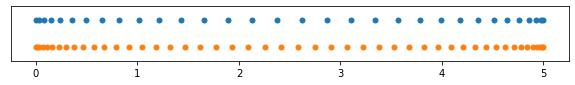

In [3]:
grid_normal = xbasis.grid(scale=1)
grid_dealias = xbasis.grid(scale=3/2)

plt.figure(figsize=(10, 1))
plt.plot(grid_normal, np.zeros_like(grid_normal)+1, 'o', markersize=5)
plt.plot(grid_dealias, np.zeros_like(grid_dealias)-1, 'o', markersize=5)
plt.ylim([-2, 2])
plt.gca().yaxis.set_ticks([]);

### Compound bases

A compound basis consisting of stacked Chebyshev segments can be constructed simply by grouping a set of individual Chebyshev bases defined over adjacent intervals.

In [4]:
xb1 = de.Chebyshev('x1', 16, interval=(0,2))
xb2 = de.Chebyshev('x2', 32, interval=(2,8))
xb3 = de.Chebyshev('x3', 16, interval=(8,10))
xbasis = de.Compound('x', (xb1, xb2, xb3))

Since we use the interior roots grid for the Chebyshev polynomials, the grid of the compound bases is simply the union of the subbasis grids.  When solving a problem with Dedalus, the continuity of fields across the subbasis interfaces is internally enforced.

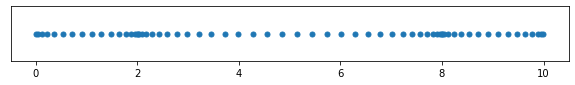

In [5]:
compound_grid = xbasis.grid(scale=1)

plt.figure(figsize=(10, 1))
plt.plot(compound_grid, np.zeros_like(compound_grid), 'o', markersize=5)
plt.gca().yaxis.set_ticks([]);

## 1.2: Domains

### Creating a domain

Domain objects represent physical domains, spanned by the direct product of a set of orthogonal bases.  To build a domain, we pass a list of the composite bases, specify the (grid-space) datatype, and optionally specify the process mesh for parallelization.  Let's construct a real 3D domain using Fourier and Chebyshev bases.

In [6]:
xbasis = de.Fourier('x', 8, interval=(0,2), dealias=3/2)
ybasis = de.Fourier('y', 8, interval=(0,2), dealias=3/2)
zbasis = de.Chebyshev('z', 8, interval=(0,1), dealias=3/2)
domain = de.Domain([xbasis, ybasis, zbasis], grid_dtype=np.float64, mesh=[1]);

### Parallelization & process mesh

Dedalus currently supports $N$-dimensional domains where the first (N-1) dimensions are separable, meaning that the linear parts of the transformed differential equations are uncoupled between modes in this subspace.  The currently implemented separable bases are the `Fourier` basis for periodic intervals, and the `SinCos` (parity) basis for problems where the variables exhibit definite parity about the interval endpoints.

Problems can be easily parallelized over the separable dimensions, and Dedalus supports distribution over arbitrary (N-1)-dimensional process meshes.  The current MPI environment must have the same number of processes as the product of the mesh shape.  By default, problems are distributed across a 1-dimensional mesh of all the available MPI processes, but specifying a higher-dimensional mesh when possible will typically improve performance.

### Layouts

The primary function of the domain object is to build the machinery necessary for the parallelized allocation and transformation of fields.  This is done by creating `layout` objects describing the necessary transform/distribution states of the data between coefficient space and grid space.  Subsequent layouts are connected by basis transforms, which must be performed locally, and global transposes (rearrangements of the data distribution across the process mesh) to achieve the required locality.

The general algorithm starts from coefficient space, with the last axis local (non-distributed).  It proceeds to grid space by transforming the last axis into grid space, globally transposing the data such that the preceding axis is local, transforming that axis into grid space, etc.  

Let's examine the layouts for the domain we just constructed:

In [7]:
for layout in domain.distributor.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [ True  True  True]
Layout 1:  Grid space: [False False  True]  Local: [ True  True  True]
Layout 2:  Grid space: [False  True  True]  Local: [ True  True  True]
Layout 3:  Grid space: [ True  True  True]  Local: [ True  True  True]


Since this is being performed serially, no global transposes are necessary (all axes are local), and the paths between layouts consist of coefficient-to-grid transforms, backwards from the last axis.

To see how things work for a distributed simulation, we'll change the process mesh and rebuild the layout objects, circumventing the internal checks on the number of available processes, etc.

**Note this is for demonstration only... messing with these attributes will generally break things.**

In [8]:
# Don't do this.
domain.distributor.mesh = np.array([4, 2])
domain.distributor.coords = np.array([0, 0])
domain.distributor._build_layouts(domain, dry_run=True)

In [9]:
for layout in domain.distributor.layouts:
    print('Layout {}:  Grid space: {}  Local: {}'.format(layout.index, layout.grid_space, layout.local))

Layout 0:  Grid space: [False False False]  Local: [False False  True]
Layout 1:  Grid space: [False False  True]  Local: [False False  True]
Layout 2:  Grid space: [False False  True]  Local: [False  True False]
Layout 3:  Grid space: [False  True  True]  Local: [False  True False]
Layout 4:  Grid space: [False  True  True]  Local: [ True False False]
Layout 5:  Grid space: [ True  True  True]  Local: [ True False False]


We can see that there are two additional layouts, corresponding to the transposed states of the mixed-transform layouts.  Two global transposes are necessary in order for the $y$ and $x$ axes to be stored locally, which is required in order to perform the respective basis transforms.

Interacting with the layout objects directly is typically not necessary, but being aware of this system for controlling the distribution and tranformation state of data is important for interacting with field objects, as we'll see in future notebooks.

### Distributed grids

Domain objects construct properly oriented arrays representing the local portions of the basis grids, for use in creating field data, setting initial conditions, etc.

The axis 0 grid is the full $x$-basis Fourier grid, since the first axis is local in grid space (i.e. the last `layout`).  The axis 1 and 2 grids are the local portions of the $y$ and $z$ basis Fourier and Chebyshev grids, distributed across the specified process mesh (4 and 2 processes, respectively).

Scale factors for the grids can be specified as a tuple (one scale for each dimension), or as a scalar to apply the same scaling to each dimension.

In [10]:
print('Grid 0 shape:', domain.grid(0, scales=1).shape)
print('Grid 1 shape:', domain.grid(1, scales=1).shape)
print('Grid 2 shape:', domain.grid(2, scales=1).shape)

Grid 0 shape: (8, 1, 1)
Grid 1 shape: (1, 2, 1)
Grid 2 shape: (1, 1, 4)
